In [ ]:
!gsutil cp gs://chem_dsrc/Dacon/UGATIT/* ./

Copying gs://chem_dsrc/Dacon/UGATIT/UGATIT.py...
Copying gs://chem_dsrc/Dacon/UGATIT/dataset.py...
Copying gs://chem_dsrc/Dacon/UGATIT/main.py...
/ [3 files][ 33.3 KiB/ 33.3 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://chem_dsrc/Dacon/UGATIT/networks.py...
Copying gs://chem_dsrc/Dacon/UGATIT/selfie2anime.zip...
Copying gs://chem_dsrc/Dacon/UGATIT/utils.py...
| [6 files][390.3 MiB/390.3 MiB]                                                
Operation completed over 6 objects/390.3 MiB.                                    


In [ ]:
!mkdir -p datset/selfie2anime

In [ ]:
# !cd datset/selfie2anime/
!unzip selfie2anime.zip -d datset/selfie2anime/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: datset/selfie2anime/trainA/female_26057.jpg  
  inflating: datset/selfie2anime/trainA/female_26059.jpg  
  inflating: datset/selfie2anime/trainA/female_26076.jpg  
  inflating: datset/selfie2anime/trainA/female_26092.jpg  
  inflating: datset/selfie2anime/trainA/female_26125.jpg  
  inflating: datset/selfie2anime/trainA/female_26139.jpg  
  inflating: datset/selfie2anime/trainA/female_26145.jpg  
  inflating: datset/selfie2anime/trainA/female_26149.jpg  
  inflating: datset/selfie2anime/trainA/female_26157.jpg  
  inflating: datset/selfie2anime/trainA/female_26167.jpg  
  inflating: datset/selfie2anime/trainA/female_26181.jpg  
  inflating: datset/selfie2anime/trainA/female_26190.jpg  
  inflating: datset/selfie2anime/trainA/female_26195.jpg  
  inflating: datset/selfie2anime/trainA/female_26219.jpg  
  inflating: datset/selfie2anime/trainA/female_26223.jpg  
  inflating: datset/selfie2anime/trainA/female_26226.jpg  
  inflating: datset/

# 프로젝트 전체 구조

- 1. 초기환경 구성
- 2. build_model()
- 3. train()
- 4. test

## 클래스 다이어그램
- 논문에 나오는 전체 구조 그림
- TQA 그림그릴것!

# 1. 초기 환경 구성

---

In [ ]:
import argparse
from utils import *

def parse_args():
    desc = "Pytorch implementation of U-GAT-IT"
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('--phase', type=str, default='train', help='[train / test]')
    parser.add_argument('--light', type=str2bool, default=False, help='[U-GAT-IT full version / U-GAT-IT light version]')
    parser.add_argument('--dataset', type=str, default='YOUR_DATASET_NAME', help='dataset_name')

    parser.add_argument('--iteration', type=int, default=1000000, help='The number of training iterations')
    parser.add_argument('--batch_size', type=int, default=1, help='The size of batch size')
    parser.add_argument('--print_loss_freq', type=int, default=1, help='The number of loss print freq')
    parser.add_argument('--print_freq', type=int, default=1000, help='The number of image print freq')
    parser.add_argument('--save_freq', type=int, default=100000, help='The number of model save freq')
    parser.add_argument('--decay_flag', type=str2bool, default=True, help='The decay_flag')

    parser.add_argument('--lr', type=float, default=0.0001, help='The learning rate')
    parser.add_argument('--weight_decay', type=float, default=0.0001, help='The weight decay')
    parser.add_argument('--adv_weight', type=int, default=1, help='Weight for GAN')
    parser.add_argument('--cycle_weight', type=int, default=10, help='Weight for Cycle')
    parser.add_argument('--identity_weight', type=int, default=10, help='Weight for Identity')
    parser.add_argument('--cam_weight', type=int, default=1000, help='Weight for CAM')

    parser.add_argument('--ch', type=int, default=32, help='base channel number per layer')
    parser.add_argument('--n_res', type=int, default=4, help='The number of resblock')
    parser.add_argument('--n_dis', type=int, default=6, help='The number of discriminator layer')

    parser.add_argument('--img_size', type=int, default=256, help='The size of image')
    parser.add_argument('--img_ch', type=int, default=3, help='The size of image channel')

    parser.add_argument('--result_dir', type=str, default='results', help='Directory name to save the results')
    parser.add_argument('--device', type=str, default='cuda', choices=['cpu', 'cuda'], help='Set gpu mode; [cpu, cuda]')
    parser.add_argument('--benchmark_flag', type=str2bool, default=False)
    parser.add_argument('--resume', type=str2bool, default=False)

    args, _ = parser.parse_known_args()
    return args
#     return check_args(args)



#### 초기 실행환경 구성 : LMS에서는 시범삼아 100 iteration만 수행 - 1분 이내 소요. (실제로는 100만 iter 수행해야 함)

In [ ]:
# Default configuration from Original Code
args = parse_args()

# Running Configuration
args.dataset = 'selfie2anime'
args.light = True
args.iteration = 100
args.print_freq = 100
args.print_loss_freq = 10
args.save_freq = 100

args

Namespace(adv_weight=1, batch_size=1, benchmark_flag=False, cam_weight=1000, ch=32, cycle_weight=10, dataset='selfie2anime', decay_flag=True, device='cuda', identity_weight=10, img_ch=3, img_size=256, iteration=100, light=True, lr=0.0001, n_dis=6, n_res=4, phase='train', print_freq=100, print_loss_freq=10, result_dir='results', resume=False, save_freq=100, weight_decay=0.0001)

In [ ]:
"""checking arguments"""
def check_args(args):
    # --result_dir
    check_folder(os.path.join(args.result_dir, args.dataset, 'model'))
    check_folder(os.path.join(args.result_dir, args.dataset, 'img'))
    check_folder(os.path.join(args.result_dir, args.dataset, 'test'))

    # --epoch
    try:
        assert args.epoch >= 1
    except:
        print('number of epochs must be larger than or equal to one')

    # --batch_size
    try:
        assert args.batch_size >= 1
    except:
        print('batch size must be larger than or equal to one')
    return args

In [ ]:
class UGATIT(object) :
    def __init__(self, args):
        self.light = args.light

        if self.light :
            self.model_name = 'UGATIT_light'
        else :
            self.model_name = 'UGATIT'

        self.result_dir = args.result_dir
        self.dataset = args.dataset

        self.iteration = args.iteration
        self.decay_flag = args.decay_flag

        self.batch_size = args.batch_size
        self.print_freq = args.print_freq
        self.save_freq = args.save_freq

        self.lr = args.lr
        self.weight_decay = args.weight_decay
        self.ch = args.ch

        """ Weight """
        self.adv_weight = args.adv_weight
        self.cycle_weight = args.cycle_weight
        self.identity_weight = args.identity_weight
        self.cam_weight = args.cam_weight

        """ Generator """
        self.n_res = args.n_res

        """ Discriminator """
        self.n_dis = args.n_dis

        self.img_size = args.img_size
        self.img_ch = args.img_ch

        self.device = args.device
        self.benchmark_flag = args.benchmark_flag
        self.resume = args.resume

        if torch.backends.cudnn.enabled and self.benchmark_flag:
            print('set benchmark !')
            torch.backends.cudnn.benchmark = True

        print()

        print("##### Information #####")
        print("# light : ", self.light)
        print("# dataset : ", self.dataset)
        print("# batch_size : ", self.batch_size)
        print("# iteration per epoch : ", self.iteration)

        print()

        print("##### Generator #####")
        print("# residual blocks : ", self.n_res)

        print()

        print("##### Discriminator #####")
        print("# discriminator layer : ", self.n_dis)

        print()

        print("##### Weight #####")
        print("# adv_weight : ", self.adv_weight)
        print("# cycle_weight : ", self.cycle_weight)
        print("# identity_weight : ", self.identity_weight)
        print("# cam_weight : ", self.cam_weight)

In [ ]:
# open session
gan = UGATIT(args)


##### Information #####
# light :  True
# dataset :  selfie2anime
# batch_size :  1
# iteration per epoch :  100

##### Generator #####
# residual blocks :  4

##### Discriminator #####
# discriminator layer :  6

##### Weight #####
# adv_weight :  1
# cycle_weight :  10
# identity_weight :  10
# cam_weight :  1000


# 2. build_model() 함수 

---

## 1) 데이터셋 구성 설명
- selfie2anime 데이터셋 구성 간단한 설명 추가할것 (TQA)
- 데이터셋 이미지를 시각화로 확인해 보는 코드 추가할 것.

In [ ]:
from dataset import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

#   Train / Test data에 대한 전처리 함수
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((gan.img_size + 30, gan.img_size+30)),
    transforms.RandomCrop(gan.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((gan.img_size, gan.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
#   Train / Test data에 대한 dataloader에 넣어준다.
gan.trainA = ImageFolder(os.path.join('dataset', gan.dataset, 'trainA'), train_transform)
gan.trainB = ImageFolder(os.path.join('dataset', gan.dataset, 'trainB'), train_transform)
gan.testA = ImageFolder(os.path.join('dataset', gan.dataset, 'testA'), test_transform)
gan.testB = ImageFolder(os.path.join('dataset', gan.dataset, 'testB'), test_transform)
gan.trainA_loader = DataLoader(gan.trainA, batch_size=gan.batch_size, shuffle=True)
gan.trainB_loader = DataLoader(gan.trainB, batch_size=gan.batch_size, shuffle=True)
gan.testA_loader = DataLoader(gan.testA, batch_size=1, shuffle=False)
gan.testB_loader = DataLoader(gan.testB, batch_size=1, shuffle=False)

In [ ]:
!cd dataset/selfie2anime/trainA

/bin/bash: line 0: cd: dataset/selfie2anime/trainA: No such file or directory


In [ ]:
gan.trainA

Dataset ImageFolder
    Number of datapoints: 3400
    Root Location: dataset/selfie2anime/trainA
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             Resize(size=(286, 286), interpolation=bilinear)
                             RandomCrop(size=(256, 256), padding=None)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [ ]:
gan.trainA_loader

## 2) U-GAT-IT 네트워크 구조 : Generator 살펴보기

In [ ]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

In [ ]:
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6, img_size=256, light=False):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.n_blocks = n_blocks
        self.img_size = img_size
        self.light = light

        DownBlock = []
        DownBlock += [nn.ReflectionPad2d(3),
                      nn.Conv2d(input_nc, ngf, kernel_size=7, stride=1, padding=0, bias=False),
                      nn.InstanceNorm2d(ngf),
                      nn.ReLU(True)]

        # Down-Sampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            DownBlock += [nn.ReflectionPad2d(1),
                          nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=0, bias=False),
                          nn.InstanceNorm2d(ngf * mult * 2),
                          nn.ReLU(True)]

        # Down-Sampling Bottleneck
        mult = 2**n_downsampling
        for i in range(n_blocks):
            DownBlock += [ResnetBlock(ngf * mult, use_bias=False)]

        # Class Activation Map
        self.gap_fc = nn.Linear(ngf * mult, 1, bias=False)
        self.gmp_fc = nn.Linear(ngf * mult, 1, bias=False)
        self.conv1x1 = nn.Conv2d(ngf * mult * 2, ngf * mult, kernel_size=1, stride=1, bias=True)
        self.relu = nn.ReLU(True)

        # Gamma, Beta block
        if self.light:
            FC = [nn.Linear(ngf * mult, ngf * mult, bias=False),
                  nn.ReLU(True),
                  nn.Linear(ngf * mult, ngf * mult, bias=False),
                  nn.ReLU(True)]
        else:
            FC = [nn.Linear(img_size // mult * img_size // mult * ngf * mult, ngf * mult, bias=False),
                  nn.ReLU(True),
                  nn.Linear(ngf * mult, ngf * mult, bias=False),
                  nn.ReLU(True)]
        self.gamma = nn.Linear(ngf * mult, ngf * mult, bias=False)
        self.beta = nn.Linear(ngf * mult, ngf * mult, bias=False)

        # Up-Sampling Bottleneck
        for i in range(n_blocks):
            setattr(self, 'UpBlock1_' + str(i+1), ResnetAdaILNBlock(ngf * mult, use_bias=False))

        # Up-Sampling
        UpBlock2 = []
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            UpBlock2 += [nn.Upsample(scale_factor=2, mode='nearest'),
                         nn.ReflectionPad2d(1),
                         nn.Conv2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=1, padding=0, bias=False),
                         ILN(int(ngf * mult / 2)),
                         nn.ReLU(True)]

        UpBlock2 += [nn.ReflectionPad2d(3),
                     nn.Conv2d(ngf, output_nc, kernel_size=7, stride=1, padding=0, bias=False),
                     nn.Tanh()]

        self.DownBlock = nn.Sequential(*DownBlock)
        self.FC = nn.Sequential(*FC)
        self.UpBlock2 = nn.Sequential(*UpBlock2)

    def forward(self, input):
        # Down-Sampling & Down-Sampling Bottleneck
        x = self.DownBlock(input)

        # CAM logit (Classifier output) 계산 및 heat map 계산
        gap = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        gap_logit = self.gap_fc(gap.view(x.shape[0], -1))
        gap_weight = list(self.gap_fc.parameters())[0]
        gap = x * gap_weight.unsqueeze(2).unsqueeze(3)

        gmp = torch.nn.functional.adaptive_max_pool2d(x, 1)
        gmp_logit = self.gmp_fc(gmp.view(x.shape[0], -1))
        gmp_weight = list(self.gmp_fc.parameters())[0]
        gmp = x * gmp_weight.unsqueeze(2).unsqueeze(3)

        cam_logit = torch.cat([gap_logit, gmp_logit], 1)
        x = torch.cat([gap, gmp], 1)
        x = self.relu(self.conv1x1(x))

        heatmap = torch.sum(x, dim=1, keepdim=True)

        # gamma, beta 계산
        if self.light:
            x_ = torch.nn.functional.adaptive_avg_pool2d(x, 1)
            x_ = self.FC(x_.view(x_.shape[0], -1))
        else:
            x_ = self.FC(x.view(x.shape[0], -1))
        gamma, beta = self.gamma(x_), self.beta(x_)

        # Up-Sampling Bottleneck 및 Up-Sampling
        for i in range(self.n_blocks):
            x = getattr(self, 'UpBlock1_' + str(i+1))(x, gamma, beta)
        out = self.UpBlock2(x)

        return out, cam_logit, heatmap

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_bias):
        super(ResnetBlock, self).__init__()
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0, bias=use_bias),
                       nn.InstanceNorm2d(dim)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [ ]:
class ResnetAdaILNBlock(nn.Module):
    def __init__(self, dim, use_bias):
        super(ResnetAdaILNBlock, self).__init__()
        self.pad1 = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0, bias=use_bias)
        self.norm1 = adaILN(dim)
        self.relu1 = nn.ReLU(True)

        self.pad2 = nn.ReflectionPad2d(1)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size=3, stride=1, padding=0, bias=use_bias)
        self.norm2 = adaILN(dim)

    def forward(self, x, gamma, beta):
        out = self.pad1(x)
        out = self.conv1(out)
        out = self.norm1(out, gamma, beta)
        out = self.relu1(out)
        out = self.pad2(out)
        out = self.conv2(out)
        out = self.norm2(out, gamma, beta)

        return out + x

In [ ]:
class adaILN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(adaILN, self).__init__()
        self.eps = eps
        self.rho = Parameter(torch.Tensor(1, num_features, 1, 1))
        self.rho.data.fill_(0.9)

    def forward(self, input, gamma, beta):
        in_mean, in_var = torch.mean(input, dim=[2, 3], keepdim=True), torch.var(input, dim=[2, 3], keepdim=True)
        out_in = (input - in_mean) / torch.sqrt(in_var + self.eps)
        ln_mean, ln_var = torch.mean(input, dim=[1, 2, 3], keepdim=True), torch.var(input, dim=[1, 2, 3], keepdim=True)
        out_ln = (input - ln_mean) / torch.sqrt(ln_var + self.eps)
        out = self.rho.expand(input.shape[0], -1, -1, -1) * out_in + (1-self.rho.expand(input.shape[0], -1, -1, -1)) * out_ln
        out = out * gamma.unsqueeze(2).unsqueeze(3) + beta.unsqueeze(2).unsqueeze(3)

        return out

In [ ]:
class ILN(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(ILN, self).__init__()
        self.eps = eps
        self.rho = Parameter(torch.Tensor(1, num_features, 1, 1))
        self.gamma = Parameter(torch.Tensor(1, num_features, 1, 1))
        self.beta = Parameter(torch.Tensor(1, num_features, 1, 1))
        self.rho.data.fill_(0.0)
        self.gamma.data.fill_(1.0)
        self.beta.data.fill_(0.0)

    def forward(self, input):
        in_mean, in_var = torch.mean(input, dim=[2, 3], keepdim=True), torch.var(input, dim=[2, 3], keepdim=True)
        out_in = (input - in_mean) / torch.sqrt(in_var + self.eps)
        ln_mean, ln_var = torch.mean(input, dim=[1, 2, 3], keepdim=True), torch.var(input, dim=[1, 2, 3], keepdim=True)
        out_ln = (input - ln_mean) / torch.sqrt(ln_var + self.eps)
        out = self.rho.expand(input.shape[0], -1, -1, -1) * out_in + (1-self.rho.expand(input.shape[0], -1, -1, -1)) * out_ln
        out = out * self.gamma.expand(input.shape[0], -1, -1, -1) + self.beta.expand(input.shape[0], -1, -1, -1)

        return out

## 3) U-GAT-IT 네트워크 구조 : Discriminator 살펴보기

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=5):
        super(Discriminator, self).__init__()
        model = [nn.ReflectionPad2d(1),
                 nn.utils.spectral_norm(
                 nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=0, bias=True)),
                 nn.LeakyReLU(0.2, True)]

        for i in range(1, n_layers - 2):
            mult = 2 ** (i - 1)
            model += [nn.ReflectionPad2d(1),
                      nn.utils.spectral_norm(
                      nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=2, padding=0, bias=True)),
                      nn.LeakyReLU(0.2, True)]

        mult = 2 ** (n_layers - 2 - 1)
        model += [nn.ReflectionPad2d(1),
                  nn.utils.spectral_norm(
                  nn.Conv2d(ndf * mult, ndf * mult * 2, kernel_size=4, stride=1, padding=0, bias=True)),
                  nn.LeakyReLU(0.2, True)]

        # Class Activation Map
        mult = 2 ** (n_layers - 2)
        self.gap_fc = nn.utils.spectral_norm(nn.Linear(ndf * mult, 1, bias=False))
        self.gmp_fc = nn.utils.spectral_norm(nn.Linear(ndf * mult, 1, bias=False))
        self.conv1x1 = nn.Conv2d(ndf * mult * 2, ndf * mult, kernel_size=1, stride=1, bias=True)
        self.leaky_relu = nn.LeakyReLU(0.2, True)

        self.pad = nn.ReflectionPad2d(1)
        self.conv = nn.utils.spectral_norm(
            nn.Conv2d(ndf * mult, 1, kernel_size=4, stride=1, padding=0, bias=False))

        self.model = nn.Sequential(*model)

    def forward(self, input):
        # Descriminator Encoder
        x = self.model(input)

        # CAM logit (Classifier output) 계산 및 heat map 계산
        gap = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        gap_logit = self.gap_fc(gap.view(x.shape[0], -1))
        gap_weight = list(self.gap_fc.parameters())[0]
        gap = x * gap_weight.unsqueeze(2).unsqueeze(3)

        gmp = torch.nn.functional.adaptive_max_pool2d(x, 1)
        gmp_logit = self.gmp_fc(gmp.view(x.shape[0], -1))
        gmp_weight = list(self.gmp_fc.parameters())[0]
        gmp = x * gmp_weight.unsqueeze(2).unsqueeze(3)

        cam_logit = torch.cat([gap_logit, gmp_logit], 1)
        x = torch.cat([gap, gmp], 1)
        x = self.leaky_relu(self.conv1x1(x))

        heatmap = torch.sum(x, dim=1, keepdim=True)

        x = self.pad(x)
        out = self.conv(x)

        return out, cam_logit, heatmap

In [ ]:
##############################################################################################
#   Generator와 Discriminator 선언

    #   genA2B: A에서 B로 변환하는 generator
    #   genB2A: B에서 A로 변환하는 generator
    #   disGA: A domain을 판단하는 global discriminator
    #   disGB: B domain을 판단하는 global discriminator
    #   disLA: A domain을 판단하는 local discriminator
    #   disLB: B domain을 판단하는 local discriminator
##############################################################################################
gan.genA2B = ResnetGenerator(input_nc=3, output_nc=3, ngf=gan.ch, n_blocks=gan.n_res, img_size=gan.img_size, light=gan.light).to(gan.device)
gan.genB2A = ResnetGenerator(input_nc=3, output_nc=3, ngf=gan.ch, n_blocks=gan.n_res, img_size=gan.img_size, light=gan.light).to(gan.device)
gan.disGA = Discriminator(input_nc=3, ndf=gan.ch, n_layers=7).to(gan.device)
gan.disGB = Discriminator(input_nc=3, ndf=gan.ch, n_layers=7).to(gan.device)
gan.disLA = Discriminator(input_nc=3, ndf=gan.ch, n_layers=5).to(gan.device)
gan.disLB = Discriminator(input_nc=3, ndf=gan.ch, n_layers=5).to(gan.device)

# 3. train() 함수

In [ ]:
def set_train(gan, train=True):
    if train:
        gan.genA2B.train()
        gan.genB2A.train()
        gan.disGA.train()
        gan.disGB.train()
        gan.disLA.train()
        gan.disLB.train()
    else:
        gan.genA2B.eval()
        gan.genB2A.eval()
        gan.disGA.eval()
        gan.disGB.eval()
        gan.disLA.eval()
        gan.disLB.eval()

In [ ]:
import time, itertools

set_train(gan, train=True)
start_iter = 1


In [ ]:
#  Training을 pretrained model에 이어서 학습 할 경우에 활용 (필요시 삭제)
if gan.resume:
    model_list = glob(os.path.join(gan.result_dir, gan.dataset, 'model', '*.pt'))
    if not len(model_list) == 0:
        model_list.sort()
        start_iter = int(model_list[-1].split('_')[-1].split('.')[0])
        gan.load(os.path.join(gan.result_dir, gan.dataset, 'model'), start_iter)
        print(" [*] Load SUCCESS")
        if gan.decay_flag and start_iter > (gan.iteration // 2):
            gan.G_optim.param_groups[0]['lr'] -= (gan.lr / (gan.iteration // 2)) * (start_iter - gan.iteration // 2)
            gan.D_optim.param_groups[0]['lr'] -= (gan.lr / (gan.iteration // 2)) * (start_iter - gan.iteration // 2)


## Full Objectives 살펴보기

In [ ]:
#   Loss Function 정의
gan.L1_loss = nn.L1Loss().to(gan.device)
gan.MSE_loss = nn.MSELoss().to(gan.device)
gan.BCE_loss = nn.BCEWithLogitsLoss().to(gan.device)

In [ ]:
#   Optimizer
gan.G_optim = torch.optim.Adam(itertools.chain(gan.genA2B.parameters(), gan.genB2A.parameters()), lr=gan.lr, betas=(0.5, 0.999), weight_decay=gan.weight_decay)
gan.D_optim = torch.optim.Adam(itertools.chain(gan.disGA.parameters(), gan.disGB.parameters(), gan.disLA.parameters(), gan.disLB.parameters()), lr=gan.lr, betas=(0.5, 0.999), weight_decay=gan.weight_decay)


In [ ]:
class RhoClipper(object):

    def __init__(self, min, max):
        self.clip_min = min
        self.clip_max = max
        assert min < max

    def __call__(self, module):

        if hasattr(module, 'rho'):
            w = module.rho.data
            w = w.clamp(self.clip_min, self.clip_max)
            module.rho.data = w

#  AdaLIN rho값을 0~1의 범위로 clipping하는 Rho clipper함수 정의
gan.Rho_clipper = RhoClipper(0, 1)

## training loop

In [ ]:
def learning_rate_decay(step, gan):
    # learning rate decay (필요시 삭제)
    if gan.decay_flag and step > (gan.iteration // 2):
        gan.G_optim.param_groups[0]['lr'] -= (gan.lr / (gan.iteration // 2))
        gan.D_optim.param_groups[0]['lr'] -= (gan.lr / (gan.iteration // 2))

In [ ]:
def get_train_data(gan):
    # training data를 dataloader에서 가져옴
    try:
        real_A, _ = trainA_iter.next()
    except:
        trainA_iter = iter(gan.trainA_loader)
        real_A, _ = trainA_iter.next()

    try:
        real_B, _ = trainB_iter.next()
    except:
        trainB_iter = iter(gan.trainB_loader)
        real_B, _ = trainB_iter.next()

    real_A, real_B = real_A.to(gan.device), real_B.to(gan.device)
    
    return real_A, real_B

In [ ]:
def update_discriminator(gan):
    gan.D_optim.zero_grad()

    # generator에 real data를 입력하여 fake 결과 출력
    fake_A2B, _, _ = gan.genA2B(real_A)
    fake_B2A, _, _ = gan.genB2A(real_B)

    # real data에 대한 discriminator 출력 
    real_GA_logit, real_GA_cam_logit, _ = gan.disGA(real_A)
    real_LA_logit, real_LA_cam_logit, _ = gan.disLA(real_A)
    real_GB_logit, real_GB_cam_logit, _ = gan.disGB(real_B)
    real_LB_logit, real_LB_cam_logit, _ = gan.disLB(real_B)

    # fake data에 대한 discriminator 출력 
    fake_GA_logit, fake_GA_cam_logit, _ = gan.disGA(fake_B2A)
    fake_LA_logit, fake_LA_cam_logit, _ = gan.disLA(fake_B2A)
    fake_GB_logit, fake_GB_cam_logit, _ = gan.disGB(fake_A2B)
    fake_LB_logit, fake_LB_cam_logit, _ = gan.disLB(fake_A2B)

    # Discriminator loss 계산 및 Discriminator Weight Update
    D_ad_loss_GA = gan.MSE_loss(real_GA_logit, torch.ones_like(real_GA_logit).to(gan.device)) + gan.MSE_loss(fake_GA_logit, torch.zeros_like(fake_GA_logit).to(gan.device))
    D_ad_cam_loss_GA = gan.MSE_loss(real_GA_cam_logit, torch.ones_like(real_GA_cam_logit).to(gan.device)) + gan.MSE_loss(fake_GA_cam_logit, torch.zeros_like(fake_GA_cam_logit).to(gan.device))
    D_ad_loss_LA = gan.MSE_loss(real_LA_logit, torch.ones_like(real_LA_logit).to(gan.device)) + gan.MSE_loss(fake_LA_logit, torch.zeros_like(fake_LA_logit).to(gan.device))
    D_ad_cam_loss_LA = gan.MSE_loss(real_LA_cam_logit, torch.ones_like(real_LA_cam_logit).to(gan.device)) + gan.MSE_loss(fake_LA_cam_logit, torch.zeros_like(fake_LA_cam_logit).to(gan.device))
    D_ad_loss_GB = gan.MSE_loss(real_GB_logit, torch.ones_like(real_GB_logit).to(gan.device)) + gan.MSE_loss(fake_GB_logit, torch.zeros_like(fake_GB_logit).to(gan.device))
    D_ad_cam_loss_GB = gan.MSE_loss(real_GB_cam_logit, torch.ones_like(real_GB_cam_logit).to(gan.device)) + gan.MSE_loss(fake_GB_cam_logit, torch.zeros_like(fake_GB_cam_logit).to(gan.device))
    D_ad_loss_LB = gan.MSE_loss(real_LB_logit, torch.ones_like(real_LB_logit).to(gan.device)) + gan.MSE_loss(fake_LB_logit, torch.zeros_like(fake_LB_logit).to(gan.device))
    D_ad_cam_loss_LB = gan.MSE_loss(real_LB_cam_logit, torch.ones_like(real_LB_cam_logit).to(gan.device)) + gan.MSE_loss(fake_LB_cam_logit, torch.zeros_like(fake_LB_cam_logit).to(gan.device))

    D_loss_A = gan.adv_weight * (D_ad_loss_GA + D_ad_cam_loss_GA + D_ad_loss_LA + D_ad_cam_loss_LA)
    D_loss_B = gan.adv_weight * (D_ad_loss_GB + D_ad_cam_loss_GB + D_ad_loss_LB + D_ad_cam_loss_LB)

    Discriminator_loss = D_loss_A + D_loss_B
    Discriminator_loss.backward()
    gan.D_optim.step()
    
    return Discriminator_loss

In [ ]:
def update_generator(gan):
    gan.G_optim.zero_grad()

    # generator에 real data를 입력하여 fake 결과 출력
    fake_A2B, fake_A2B_cam_logit, _ = gan.genA2B(real_A)
    fake_B2A, fake_B2A_cam_logit, _ = gan.genB2A(real_B)

    # Cycle Loss계산을 위한  generation 결과 출력
    fake_A2B2A, _, _ = gan.genB2A(fake_A2B)
    fake_B2A2B, _, _ = gan.genA2B(fake_B2A)

    # identity loss 및 cam loss 계산을 위한 gerneration 결과 출력
    fake_A2A, fake_A2A_cam_logit, _ = gan.genB2A(real_A)
    fake_B2B, fake_B2B_cam_logit, _ = gan.genA2B(real_B)

    # fake data에 대한 discriminator 출력  
    fake_GA_logit, fake_GA_cam_logit, _ = gan.disGA(fake_B2A)
    fake_LA_logit, fake_LA_cam_logit, _ = gan.disLA(fake_B2A)
    fake_GB_logit, fake_GB_cam_logit, _ = gan.disGB(fake_A2B)
    fake_LB_logit, fake_LB_cam_logit, _ = gan.disLB(fake_A2B)

    # Generator loss 계산 및 Generator Weight Update
    G_ad_loss_GA = gan.MSE_loss(fake_GA_logit, torch.ones_like(fake_GA_logit).to(gan.device))
    G_ad_cam_loss_GA = gan.MSE_loss(fake_GA_cam_logit, torch.ones_like(fake_GA_cam_logit).to(gan.device))
    G_ad_loss_LA = gan.MSE_loss(fake_LA_logit, torch.ones_like(fake_LA_logit).to(gan.device))
    G_ad_cam_loss_LA = gan.MSE_loss(fake_LA_cam_logit, torch.ones_like(fake_LA_cam_logit).to(gan.device))
    G_ad_loss_GB = gan.MSE_loss(fake_GB_logit, torch.ones_like(fake_GB_logit).to(gan.device))
    G_ad_cam_loss_GB = gan.MSE_loss(fake_GB_cam_logit, torch.ones_like(fake_GB_cam_logit).to(gan.device))
    G_ad_loss_LB = gan.MSE_loss(fake_LB_logit, torch.ones_like(fake_LB_logit).to(gan.device))
    G_ad_cam_loss_LB = gan.MSE_loss(fake_LB_cam_logit, torch.ones_like(fake_LB_cam_logit).to(gan.device))

    G_recon_loss_A = gan.L1_loss(fake_A2B2A, real_A)
    G_recon_loss_B = gan.L1_loss(fake_B2A2B, real_B)

    G_identity_loss_A = gan.L1_loss(fake_A2A, real_A)
    G_identity_loss_B = gan.L1_loss(fake_B2B, real_B)

    G_cam_loss_A = gan.BCE_loss(fake_B2A_cam_logit, torch.ones_like(fake_B2A_cam_logit).to(gan.device)) + gan.BCE_loss(fake_A2A_cam_logit, torch.zeros_like(fake_A2A_cam_logit).to(gan.device))
    G_cam_loss_B = gan.BCE_loss(fake_A2B_cam_logit, torch.ones_like(fake_A2B_cam_logit).to(gan.device)) + gan.BCE_loss(fake_B2B_cam_logit, torch.zeros_like(fake_B2B_cam_logit).to(gan.device))

    G_loss_A =  gan.adv_weight * (G_ad_loss_GA + G_ad_cam_loss_GA + G_ad_loss_LA + G_ad_cam_loss_LA) + gan.cycle_weight * G_recon_loss_A + gan.identity_weight * G_identity_loss_A + gan.cam_weight * G_cam_loss_A
    G_loss_B = gan.adv_weight * (G_ad_loss_GB + G_ad_cam_loss_GB + G_ad_loss_LB + G_ad_cam_loss_LB) + gan.cycle_weight * G_recon_loss_B + gan.identity_weight * G_identity_loss_B + gan.cam_weight * G_cam_loss_B

    Generator_loss = G_loss_A + G_loss_B
    Generator_loss.backward()
    gan.G_optim.step()
    
    return Generator_loss

In [ ]:
def gen_interim_result(gan, A2B, B2A, A_loader, B_loader):
    try:
        real_A, _ = A_iter.next()
    except:
        A_iter = iter(A_loader)
        real_A, _ = A_iter.next()

    try:
        real_B, _ = B_iter.next()
    except:
        B_iter = iter(B_loader)
        real_B, _ = B_iter.next()
    real_A, real_B = real_A.to(gan.device), real_B.to(gan.device)

    fake_A2B, _, fake_A2B_heatmap = gan.genA2B(real_A)
    fake_B2A, _, fake_B2A_heatmap = gan.genB2A(real_B)

    fake_A2B2A, _, fake_A2B2A_heatmap = gan.genB2A(fake_A2B)
    fake_B2A2B, _, fake_B2A2B_heatmap = gan.genA2B(fake_B2A)

    fake_A2A, _, fake_A2A_heatmap = gan.genB2A(real_A)
    fake_B2B, _, fake_B2B_heatmap = gan.genA2B(real_B)

    A2B = np.concatenate((A2B, np.concatenate((RGB2BGR(tensor2numpy(denorm(real_A[0]))),
                                                cam(tensor2numpy(fake_A2A_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_A2A[0]))),
                                                cam(tensor2numpy(fake_A2B_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_A2B[0]))),
                                                cam(tensor2numpy(fake_A2B2A_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_A2B2A[0])))), 0)), 1)

    B2A = np.concatenate((B2A, np.concatenate((RGB2BGR(tensor2numpy(denorm(real_B[0]))),
                                                cam(tensor2numpy(fake_B2B_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_B2B[0]))),
                                                cam(tensor2numpy(fake_B2A_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_B2A[0]))),
                                                cam(tensor2numpy(fake_B2A2B_heatmap[0]), gan.img_size),
                                                RGB2BGR(tensor2numpy(denorm(fake_B2A2B[0])))), 0)), 1)
    del fake_A2B, fake_A2B_heatmap, fake_B2A, fake_B2A_heatmap
    del fake_A2B2A, fake_A2B2A_heatmap, fake_B2A2B, fake_B2A2B_heatmap
    del fake_A2A, fake_A2A_heatmap, fake_B2B, fake_B2B_heatmap
    torch.cuda.empty_cache()
    
    return A2B, B2A

In [ ]:
def show_interim_result(step, gan):
    train_sample_num = 5
    test_sample_num = 5
    A2B = np.zeros((gan.img_size * 7, 0, 3))
    B2A = np.zeros((gan.img_size * 7, 0, 3))
    
    set_train(gan, train=False)
    
    for _ in range(train_sample_num):
        A2B, B2A = gen_interim_result(gan, A2B, B2A, gan.trainA_loader, gan.trainB_loader)
        
    for _ in range(test_sample_num):
        A2B, B2A = gen_interim_result(gan, A2B, B2A, gan.testA_loader, gan.testB_loader)
        
    #print(os.path.join(gan.result_dir, gan.dataset, 'img', 'A2B_%07d.png' % step))
    cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'img', 'A2B_%07d.png' % step), A2B * 255.0)
    cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'img', 'B2A_%07d.png' % step), B2A * 255.0)

    set_train(gan, train=True)

In [ ]:
def save(gan, dir, step):
    params = {}
    params['genA2B'] = gan.genA2B.state_dict()
    params['genB2A'] = gan.genB2A.state_dict()
    params['disGA'] = gan.disGA.state_dict()
    params['disGB'] = gan.disGB.state_dict()
    params['disLA'] = gan.disLA.state_dict()
    params['disLB'] = gan.disLB.state_dict()
    torch.save(params, os.path.join(dir, gan.dataset + '_params_%07d.pt' % step))

def load(gan, dir, step):
    params = torch.load(os.path.join(dir, gan.dataset + '_params_%07d.pt' % step))
    gan.genA2B.load_state_dict(params['genA2B'])
    gan.genB2A.load_state_dict(params['genB2A'])
    gan.disGA.load_state_dict(params['disGA'])
    gan.disGB.load_state_dict(params['disGB'])
    gan.disLA.load_state_dict(params['disLA'])
    gan.disLB.load_state_dict(params['disLB'])

In [ ]:
def save_weight(step, gan):
    if step % gan.save_freq == 0:
        save(gan, os.path.join(gan.result_dir, gan.dataset, 'model'), step)

    if step % 1000 == 0:
        #print(os.path.join(gan.result_dir, gan.dataset + '_params_latest.pt'))
        params = {}
        params['genA2B'] = gan.genA2B.state_dict()
        params['genB2A'] = gan.genB2A.state_dict()
        params['disGA'] = gan.disGA.state_dict()
        params['disGB'] = gan.disGB.state_dict()
        params['disLA'] = gan.disLA.state_dict()
        params['disLB'] = gan.disLB.state_dict()
        torch.save(params, os.path.join(gan.result_dir, gan.dataset + '_params_latest.pt'))


In [ ]:
!mkdir -p results/selfie2anime/model/

In [ ]:
save_weight(step, gan)

In [ ]:
#########################################################################################################################
#  Training Loop
#########################################################################################################################


print('training start !')
start_time = time.time()
for step in range(start_iter, gan.iteration + 1):
    learning_rate_decay(step, gan)
    real_A, real_B = get_train_data(gan)
    
    # Update Discriminator
    Discriminator_loss = update_discriminator(gan)
    
    # Update Generator
    Generator_loss = update_generator(gan)
    
    # clip parameter of AdaILN, applied after optimizer step
    gan.genA2B.apply(gan.Rho_clipper)
    gan.genB2A.apply(gan.Rho_clipper)

    # 학습진행 상황 출력
    print("[%5d/%5d] time: %4.4f d_loss: %.8f, g_loss: %.8f" % (step, gan.iteration, time.time() - start_time, Discriminator_loss, Generator_loss))

    # iteration이 gan.print_freq (ex. 1000) 횟수 마다 결과 이미지 출력 (result/img 폴더)
    if step % gan.print_freq == 0:
        show_interim_result(step, gan)
    
    # 모델 weight 저장
    save_weight(step, gan)
        
    

training start !
[    1/  100] time: 0.7279 d_loss: 7.87098455, g_loss: 7775.41748047
[    2/  100] time: 1.1629 d_loss: 6.26835251, g_loss: 6354.13427734
[    3/  100] time: 1.6093 d_loss: 5.77628136, g_loss: 5884.47460938
[    4/  100] time: 2.0466 d_loss: 5.37188053, g_loss: 3384.48193359
[    5/  100] time: 2.4809 d_loss: 4.89587593, g_loss: 1845.78100586
[    6/  100] time: 2.9189 d_loss: 4.66406918, g_loss: 2297.70092773
[    7/  100] time: 3.3555 d_loss: 4.36539078, g_loss: 1933.24597168
[    8/  100] time: 3.7869 d_loss: 4.96175671, g_loss: 2677.72216797
[    9/  100] time: 4.2224 d_loss: 4.73234224, g_loss: 2915.44189453
[   10/  100] time: 4.6576 d_loss: 4.00406981, g_loss: 2801.04345703
[   11/  100] time: 5.0970 d_loss: 3.77335167, g_loss: 2336.12866211
[   12/  100] time: 5.5327 d_loss: 3.83134222, g_loss: 2123.76489258
[   13/  100] time: 5.9651 d_loss: 5.05130863, g_loss: 3282.31054688
[   14/  100] time: 6.3972 d_loss: 4.20468616, g_loss: 2120.91894531
[   15/  100] tim

FileNotFoundError: ignored

### TQA : train 중간결과물 확인하기

# 4. test() 함수

In [ ]:
from glob import glob

def test(gan):
    model_list = glob(os.path.join(gan.result_dir, gan.dataset, 'model', '*.pt'))
    if not len(model_list) == 0:
        model_list.sort()
        iter = int(model_list[-1].split('_')[-1].split('.')[0])
        load(gan, os.path.join(gan.result_dir, gan.dataset, 'model'), iter)
        print(" [*] Load SUCCESS")
    else:
        print(" [*] Load FAILURE")
        return

    gan.genA2B.eval(), gan.genB2A.eval()
    for n, (real_A, _) in enumerate(gan.testA_loader):
        real_A = real_A.to(gan.device)

        fake_A2B, _, fake_A2B_heatmap = gan.genA2B(real_A)

        fake_A2B2A, _, fake_A2B2A_heatmap = gan.genB2A(fake_A2B)

        fake_A2A, _, fake_A2A_heatmap = gan.genB2A(real_A)

        A2B = np.concatenate((RGB2BGR(tensor2numpy(denorm(real_A[0]))),
                                cam(tensor2numpy(fake_A2A_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_A2A[0]))),
                                cam(tensor2numpy(fake_A2B_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_A2B[0]))),
                                cam(tensor2numpy(fake_A2B2A_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_A2B2A[0])))), 0)

        cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'test', 'A2B_%d.png' % (n + 1)), A2B * 255.0)

    for n, (real_B, _) in enumerate(gan.testB_loader):
        real_B = real_B.to(gan.device)

        fake_B2A, _, fake_B2A_heatmap = gan.genB2A(real_B)

        fake_B2A2B, _, fake_B2A2B_heatmap = gan.genA2B(fake_B2A)

        fake_B2B, _, fake_B2B_heatmap = gan.genA2B(real_B)

        B2A = np.concatenate((RGB2BGR(tensor2numpy(denorm(real_B[0]))),
                                cam(tensor2numpy(fake_B2B_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_B2B[0]))),
                                cam(tensor2numpy(fake_B2A_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_B2A[0]))),
                                cam(tensor2numpy(fake_B2A2B_heatmap[0]), gan.img_size),
                                RGB2BGR(tensor2numpy(denorm(fake_B2A2B[0])))), 0)

        cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'test', 'B2A_%d.png' % (n + 1)), B2A * 255.0)


In [51]:
gan

In [53]:
model_list = glob(os.path.join(gan.result_dir, gan.dataset, 'model', '*.pt'))
if not len(model_list) == 0:
    model_list.sort()
    iter = int(model_list[-1].split('_')[-1].split('.')[0])
    load(gan, os.path.join(gan.result_dir, gan.dataset, 'model'), iter)
    print(" [*] Load SUCCESS")
else:
    print(" [*] Load FAILURE")
    # return

gan.genA2B.eval(), gan.genB2A.eval()
for n, (real_A, _) in enumerate(gan.testA_loader):
    real_A = real_A.to(gan.device)

    fake_A2B, _, fake_A2B_heatmap = gan.genA2B(real_A)

    fake_A2B2A, _, fake_A2B2A_heatmap = gan.genB2A(fake_A2B)

    fake_A2A, _, fake_A2A_heatmap = gan.genB2A(real_A)

    A2B = np.concatenate((RGB2BGR(tensor2numpy(denorm(real_A[0]))),
                            cam(tensor2numpy(fake_A2A_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_A2A[0]))),
                            cam(tensor2numpy(fake_A2B_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_A2B[0]))),
                            cam(tensor2numpy(fake_A2B2A_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_A2B2A[0])))), 0)

    cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'test', 'A2B_%d.png' % (n + 1)), A2B * 255.0)

for n, (real_B, _) in enumerate(gan.testB_loader):
    real_B = real_B.to(gan.device)

    fake_B2A, _, fake_B2A_heatmap = gan.genB2A(real_B)

    fake_B2A2B, _, fake_B2A2B_heatmap = gan.genA2B(fake_B2A)

    fake_B2B, _, fake_B2B_heatmap = gan.genA2B(real_B)

    B2A = np.concatenate((RGB2BGR(tensor2numpy(denorm(real_B[0]))),
                            cam(tensor2numpy(fake_B2B_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_B2B[0]))),
                            cam(tensor2numpy(fake_B2A_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_B2A[0]))),
                            cam(tensor2numpy(fake_B2A2B_heatmap[0]), gan.img_size),
                            RGB2BGR(tensor2numpy(denorm(fake_B2A2B[0])))), 0)

    cv2.imwrite(os.path.join(gan.result_dir, gan.dataset, 'test', 'B2A_%d.png' % (n + 1)), B2A * 255.0)


 [*] Load SUCCESS


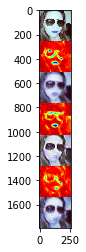

In [60]:
from matplotlib import pyplot as plt
plt.imshow(A2B, interpolation='nearest')
plt.show()

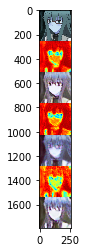

In [59]:
from matplotlib import pyplot as plt
plt.imshow(B2A, interpolation='nearest')
plt.show()

In [58]:
B2A

array([[[0.04705882, 0.0862745 , 0.10980392],
        [0.05098039, 0.09411764, 0.11372548],
        [0.06274509, 0.10588235, 0.12941176],
        ...,
        [0.05882353, 0.0862745 , 0.07843137],
        [0.05098039, 0.0745098 , 0.06274509],
        [0.05098039, 0.0745098 , 0.06274509]],

       [[0.04313725, 0.0862745 , 0.10980392],
        [0.04705882, 0.09411764, 0.11372548],
        [0.06274509, 0.10588235, 0.12549019],
        ...,
        [0.05882353, 0.0862745 , 0.07843137],
        [0.05490196, 0.07843137, 0.06666666],
        [0.05490196, 0.0745098 , 0.06666666]],

       [[0.04313725, 0.0862745 , 0.10588235],
        [0.04705882, 0.09019607, 0.10980392],
        [0.06274509, 0.10196078, 0.12549019],
        ...,
        [0.05882353, 0.0862745 , 0.0745098 ],
        [0.05490196, 0.07843137, 0.07058823],
        [0.05490196, 0.07843137, 0.06666666]],

       ...,

       [[0.2266427 , 0.19485277, 0.13790882],
        [0.2302959 , 0.19699162, 0.12955526],
        [0.23052078, 0

In [56]:
os.path.join(gan.result_dir, gan.dataset)

'results/selfie2anime'

In [50]:
test(gan)

 [*] Load SUCCESS


### TQA : test 중간결과물 확인하기